In [21]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [2]:
!git clone https://github.com/muxspace/facial_expressions

fatal: destination path 'facial_expressions' already exists and is not an empty directory.


In [3]:
dataset = pd.read_csv("facial_expressions/data/legend.csv")
dataset = dataset.drop(["user.id"], axis=1)
dataset['emotion'] = dataset['emotion'].str.lower()

In [4]:
class_mapping = dict( zip( dataset["emotion"].astype('category').cat.codes, dataset["emotion"]))
dataset["emotion_class"] = dataset["emotion"].astype('category').cat.codes

In [5]:
for i in sorted(class_mapping.keys()):
  print(i, class_mapping[i])

dataset.head(10)

0 anger
1 contempt
2 disgust
3 fear
4 happiness
5 neutral
6 sadness
7 surprise


,image,emotion,emotion_class
0,facial-expressions_2868588k.jpg,anger,0
1,facial-expressions_2868585k.jpg,surprise,7
2,facial-expressions_2868584k.jpg,disgust,2
3,facial-expressions_2868582k.jpg,fear,3
4,Aaron_Eckhart_0001.jpg,neutral,5
5,Aaron_Guiel_0001.jpg,happiness,4
6,Aaron_Patterson_0001.jpg,neutral,5
7,Aaron_Peirsol_0001.jpg,happiness,4
8,Aaron_Peirsol_0002.jpg,happiness,4
9,Aaron_Peirsol_0003.jpg,happiness,4


# Emotion Class Distribution

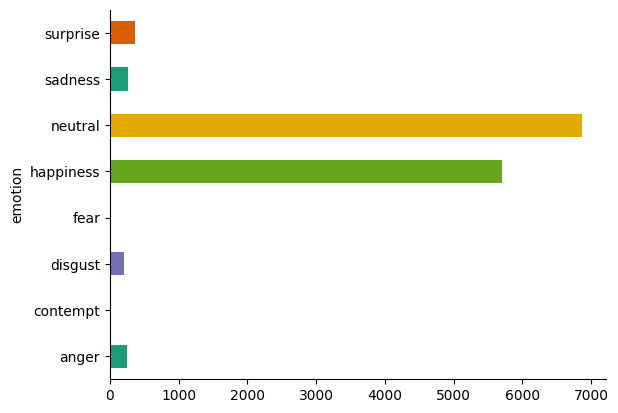

In [6]:
# @title Emotion Class Distribution

dataset.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
xtrain, xval, ytrain, yval = train_test_split(dataset["image"], dataset["emotion_class"], test_size=0.2, random_state=77, stratify=dataset["emotion_class"])
np.unique(ytrain)
weights = compute_class_weight(class_weight="balanced", classes=np.unique(ytrain), y=ytrain)

In [8]:
xtraindata = np.zeros((len(xtrain), 128, 128, 3))
xvaldata = np.zeros((len(xval), 128, 128, 3))
wierd_list = []
for i in range(len(xtrain)):
    xtraindata[i] = cv2.resize(cv2.imread("facial_expressions/images/" + xtrain.iloc[i]), (128,128)) / 255.             # resizing due to colab RAM constraints and then normalize

for i in range(len(xval)):
    xvaldata[i] = cv2.resize(cv2.imread("facial_expressions/images/" + xval.iloc[i]), (128,128)) / 255.

# Flattened image data for non-spatial models
xtraindata_flat = xtraindata.reshape(len(xtraindata), -1)
xvaldata_flat = xvaldata.reshape(len(xvaldata), -1)

# KNN

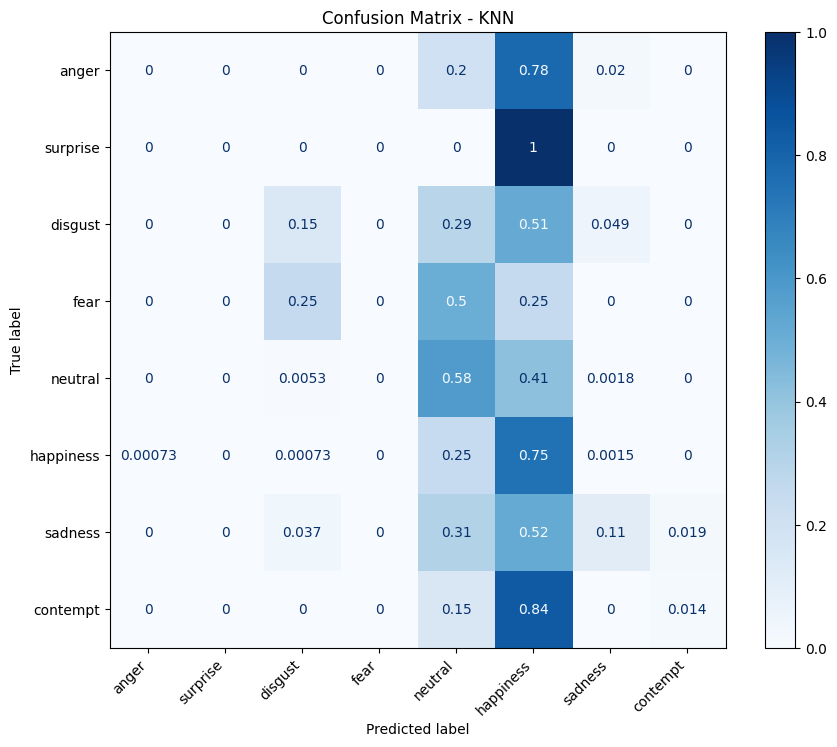

Accuracy: 0.6205
F1 Score: 0.5980
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        50
    surprise       0.00      0.00      0.00         2
     disgust       0.38      0.15      0.21        41
        fear       0.00      0.00      0.00         4
     neutral       0.63      0.58      0.60      1139
   happiness       0.62      0.75      0.68      1374
     sadness       0.46      0.11      0.18        54
    contempt       0.50      0.01      0.03        74

    accuracy                           0.62      2738
   macro avg       0.32      0.20      0.21      2738
weighted avg       0.60      0.62      0.60      2738



c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan')
knn.fit(xtraindata_flat, ytrain)

y_pred = knn.predict(xvaldata_flat)

cm = confusion_matrix(yval, y_pred,  normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_mapping.values()))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix - KNN")
plt.show()

accuracy = accuracy_score(yval, y_pred)
f1 = f1_score(yval, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(yval, y_pred, target_names=list(class_mapping.values())))


# Decision Trees

Training Decision Tree...


Predicting with Decision Tree: 100%|██████████| 28/28 [00:00<00:00, 59.99it/s]


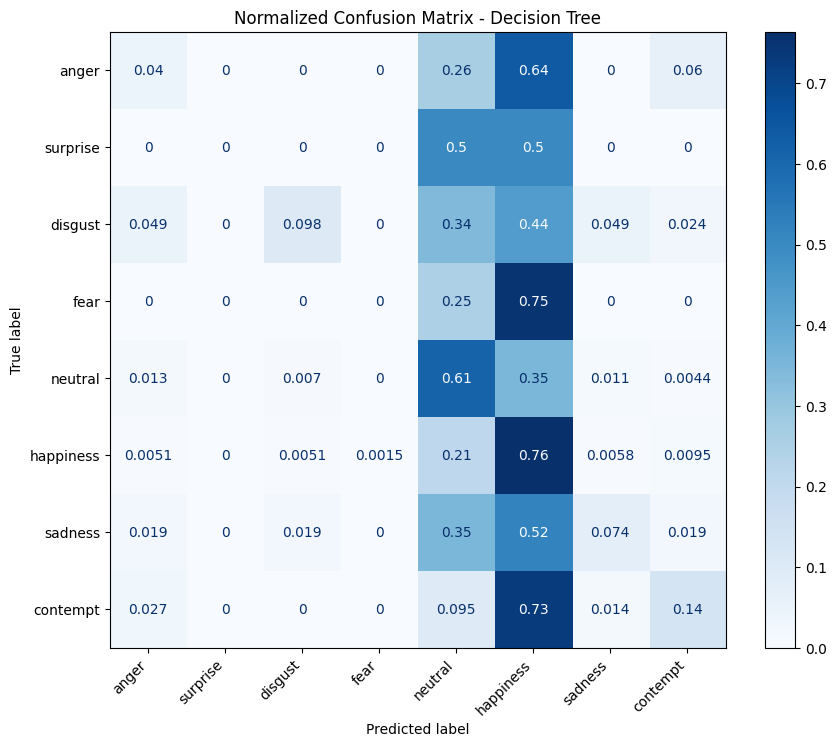

Accuracy: 0.6457
F1 Score: 0.6323
Classification Report:
               precision    recall  f1-score   support

       anger       0.07      0.04      0.05        50
    surprise       0.00      0.00      0.00         2
     disgust       0.20      0.10      0.13        41
        fear       0.00      0.00      0.00         4
     neutral       0.67      0.61      0.64      1139
   happiness       0.66      0.76      0.71      1374
     sadness       0.15      0.07      0.10        54
    contempt       0.30      0.14      0.19        74

    accuracy                           0.65      2738
   macro avg       0.26      0.22      0.23      2738
weighted avg       0.63      0.65      0.63      2738



c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from tqdm import tqdm
import numpy as np

# Initialize Decision Tree model
tree = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)

# Train the model
print("Training Decision Tree...")
tree.fit(xtraindata_flat, ytrain)

# Use tqdm for prediction
batch_size = 100  # Number of samples to process per batch
num_batches = len(xvaldata_flat) // batch_size + (1 if len(xvaldata_flat) % batch_size > 0 else 0)
y_pred = []

for i in tqdm(range(num_batches), desc="Predicting with Decision Tree"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(xvaldata_flat))
    y_pred.extend(tree.predict(xvaldata_flat[start_idx:end_idx]))

y_pred = np.array(y_pred)  # Convert back to numpy array

# Confusion matrix
cm = confusion_matrix(yval, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_mapping.values()))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title("Normalized Confusion Matrix - Decision Tree")
plt.show()

# Evaluation metrics
accuracy = accuracy_score(yval, y_pred)
f1 = f1_score(yval, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(yval, y_pred, target_names=list(class_mapping.values())))


# Gradient Boosting

C:\Users\Jeffrey8\AppData\Local\Temp\ipykernel_194696\2127989409.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtraindata_flat = torch.tensor(xtraindata_flat, dtype=torch.float32)
C:\Users\Jeffrey8\AppData\Local\Temp\ipykernel_194696\2127989409.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvaldata_flat = torch.tensor(xvaldata_flat, dtype=torch.float32)
Epoch 1: 100%|██████████| 172/172 [00:02<00:00, 69.23batch/s, accuracy=55.2, loss=0.209]


Validation Loss: 0.8960, Validation Accuracy: 71.80%


Epoch 2: 100%|██████████| 172/172 [00:02<00:00, 68.55batch/s, accuracy=69.2, loss=0.103]


Validation Loss: 0.7811, Validation Accuracy: 70.01%


Epoch 3: 100%|██████████| 172/172 [00:02<00:00, 69.32batch/s, accuracy=71.1, loss=0.0981]


Validation Loss: 0.7159, Validation Accuracy: 75.79%


Epoch 4: 100%|██████████| 172/172 [00:02<00:00, 63.23batch/s, accuracy=72.9, loss=0.0921]


Validation Loss: 0.7111, Validation Accuracy: 74.54%


Epoch 5: 100%|██████████| 172/172 [00:02<00:00, 69.54batch/s, accuracy=71.5, loss=0.0952]


Validation Loss: 0.7609, Validation Accuracy: 71.59%


Epoch 6: 100%|██████████| 172/172 [00:02<00:00, 69.99batch/s, accuracy=72.7, loss=0.0918]


Validation Loss: 0.6979, Validation Accuracy: 74.43%


Epoch 7: 100%|██████████| 172/172 [00:02<00:00, 70.25batch/s, accuracy=73.8, loss=0.0891]


Validation Loss: 0.7268, Validation Accuracy: 73.41%


Epoch 8: 100%|██████████| 172/172 [00:02<00:00, 71.86batch/s, accuracy=74.2, loss=0.0876]


Validation Loss: 0.6955, Validation Accuracy: 74.76%


Epoch 9: 100%|██████████| 172/172 [00:02<00:00, 72.86batch/s, accuracy=75.9, loss=0.0845]


Validation Loss: 0.7243, Validation Accuracy: 72.94%


Epoch 10: 100%|██████████| 172/172 [00:02<00:00, 68.60batch/s, accuracy=74.8, loss=0.0865]


Validation Loss: 0.6888, Validation Accuracy: 75.05%


Epoch 11: 100%|██████████| 172/172 [00:02<00:00, 67.29batch/s, accuracy=74.9, loss=0.0842]


Validation Loss: 0.6777, Validation Accuracy: 76.81%


Epoch 12: 100%|██████████| 172/172 [00:02<00:00, 70.31batch/s, accuracy=77.1, loss=0.0813]


Validation Loss: 0.6790, Validation Accuracy: 76.52%


Epoch 13: 100%|██████████| 172/172 [00:02<00:00, 67.98batch/s, accuracy=75.7, loss=0.0834]


Validation Loss: 0.6696, Validation Accuracy: 76.37%


Epoch 14: 100%|██████████| 172/172 [00:02<00:00, 71.56batch/s, accuracy=77, loss=0.0806] 


Validation Loss: 0.6881, Validation Accuracy: 76.04%


Epoch 15: 100%|██████████| 172/172 [00:02<00:00, 70.08batch/s, accuracy=76.2, loss=0.0824]


Validation Loss: 0.6775, Validation Accuracy: 76.00%


Epoch 16: 100%|██████████| 172/172 [00:02<00:00, 71.80batch/s, accuracy=77.4, loss=0.0785]


Validation Loss: 0.8758, Validation Accuracy: 68.33%


Epoch 17: 100%|██████████| 172/172 [00:02<00:00, 68.46batch/s, accuracy=77.1, loss=0.0798]


Validation Loss: 0.6607, Validation Accuracy: 78.01%


Epoch 18: 100%|██████████| 172/172 [00:02<00:00, 72.07batch/s, accuracy=76.9, loss=0.0788]


Validation Loss: 1.0060, Validation Accuracy: 63.00%


Epoch 19: 100%|██████████| 172/172 [00:02<00:00, 70.33batch/s, accuracy=76, loss=0.0806] 


Validation Loss: 0.7499, Validation Accuracy: 71.91%


Epoch 20: 100%|██████████| 172/172 [00:02<00:00, 71.00batch/s, accuracy=78, loss=0.0768] 


Validation Loss: 0.6893, Validation Accuracy: 74.80%


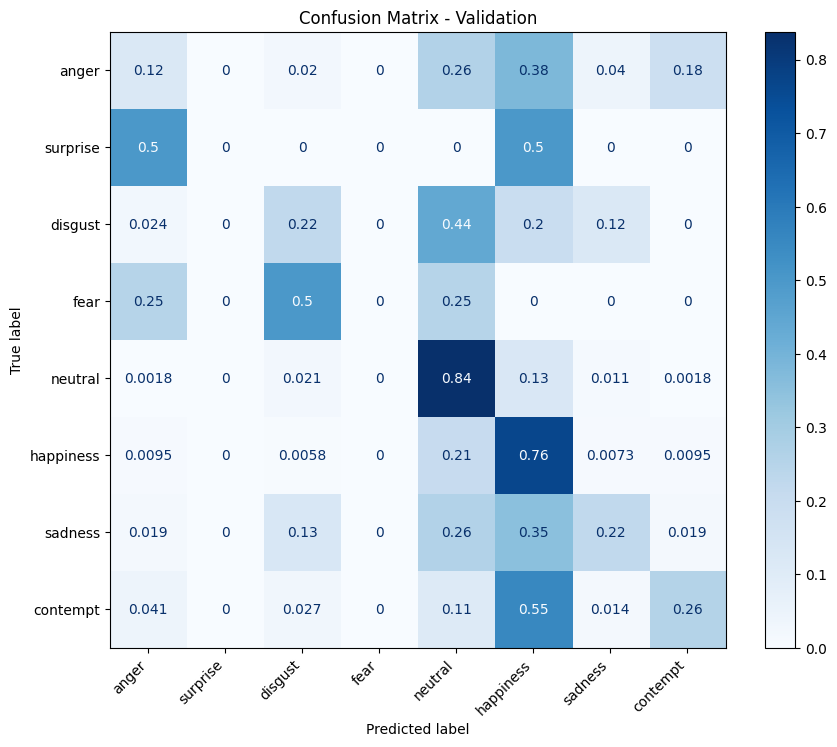

Validation Accuracy: 74.80%
F1 Score: 0.7422
Classification Report (Validation):
              precision    recall  f1-score   support

       anger       0.21      0.12      0.15        50
    surprise       0.00      0.00      0.00         2
     disgust       0.17      0.22      0.19        41
        fear       0.00      0.00      0.00         4
     neutral       0.74      0.84      0.79      1139
   happiness       0.82      0.76      0.79      1374
     sadness       0.29      0.22      0.25        54
    contempt       0.43      0.26      0.32        74

    accuracy                           0.75      2738
   macro avg       0.33      0.30      0.31      2738
weighted avg       0.74      0.75      0.74      2738



c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [ ]:
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbt.fit(xtraindata_flat, ytrain)
y_pred_gbt = gbt.predict(xvaldata_flat)

cm_gbt = confusion_matrix(yval, y_pred_gbt)
disp_gbt = ConfusionMatrixDisplay(confusion_matrix=cm_gbt, display_labels=list(class_mapping.values()))
fig, ax = plt.subplots(figsize=(10, 8))
disp_gbt.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix - Gradient Boosting Trees")
plt.show()

accuracy_gbt = accuracy_score(yval, y_pred_gbt)
f1_gbt = f1_score(yval, y_pred_gbt, average='weighted')

print(f"Accuracy: {accuracy_gbt:.4f}")
print(f"F1 Score: {f1_gbt:.4f}")
print("Classification Report:\n", classification_report(yval, y_pred_gbt, target_names=list(class_mapping.values())))

# MLP

C:\Users\Jeffrey8\AppData\Local\Temp\ipykernel_194696\2753492100.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtraindata_flat = torch.tensor(xtraindata_flat, dtype=torch.float32)
C:\Users\Jeffrey8\AppData\Local\Temp\ipykernel_194696\2753492100.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvaldata_flat = torch.tensor(xvaldata_flat, dtype=torch.float32)
Epoch 1: 100%|██████████| 172/172 [00:03<00:00, 57.05batch/s, accuracy=56, loss=0.2]   


Validation Loss: 0.8846, Validation Accuracy: 68.52%


Epoch 2: 100%|██████████| 172/172 [00:03<00:00, 47.76batch/s, accuracy=68.1, loss=0.104]


Validation Loss: 0.8041, Validation Accuracy: 70.78%


Epoch 3: 100%|██████████| 172/172 [00:03<00:00, 48.72batch/s, accuracy=71.3, loss=0.0977]


Validation Loss: 0.7296, Validation Accuracy: 75.31%


Epoch 4: 100%|██████████| 172/172 [00:02<00:00, 61.74batch/s, accuracy=73.2, loss=0.0918]


Validation Loss: 0.7667, Validation Accuracy: 72.32%


Epoch 5: 100%|██████████| 172/172 [00:02<00:00, 62.70batch/s, accuracy=72.4, loss=0.0935]


Validation Loss: 0.7472, Validation Accuracy: 71.07%


Epoch 6: 100%|██████████| 172/172 [00:02<00:00, 58.28batch/s, accuracy=72.9, loss=0.0925]


Validation Loss: 0.7384, Validation Accuracy: 72.97%


Epoch 7: 100%|██████████| 172/172 [00:02<00:00, 60.49batch/s, accuracy=73.4, loss=0.0904]


Validation Loss: 0.7876, Validation Accuracy: 69.10%


Epoch 8: 100%|██████████| 172/172 [00:02<00:00, 62.22batch/s, accuracy=75.6, loss=0.0858]


Validation Loss: 0.6989, Validation Accuracy: 76.04%


Epoch 9: 100%|██████████| 172/172 [00:02<00:00, 58.21batch/s, accuracy=75.5, loss=0.0857]


Validation Loss: 0.7393, Validation Accuracy: 72.94%


Epoch 10: 100%|██████████| 172/172 [00:02<00:00, 63.20batch/s, accuracy=75.8, loss=0.0851]


Validation Loss: 0.6785, Validation Accuracy: 76.77%


Epoch 11: 100%|██████████| 172/172 [00:02<00:00, 64.40batch/s, accuracy=76.2, loss=0.0832]


Validation Loss: 0.8409, Validation Accuracy: 67.28%


Epoch 12: 100%|██████████| 172/172 [00:02<00:00, 58.17batch/s, accuracy=75.4, loss=0.0844]


Validation Loss: 0.6753, Validation Accuracy: 76.63%


Epoch 13: 100%|██████████| 172/172 [00:02<00:00, 63.83batch/s, accuracy=76.3, loss=0.0825]


Validation Loss: 0.6783, Validation Accuracy: 76.52%


Epoch 14: 100%|██████████| 172/172 [00:02<00:00, 59.61batch/s, accuracy=76.7, loss=0.0812]


Validation Loss: 0.8068, Validation Accuracy: 70.20%


Epoch 15: 100%|██████████| 172/172 [00:02<00:00, 60.28batch/s, accuracy=76.7, loss=0.0811]


Validation Loss: 0.6998, Validation Accuracy: 76.41%


Epoch 16: 100%|██████████| 172/172 [00:02<00:00, 58.32batch/s, accuracy=76.2, loss=0.0823]


Validation Loss: 0.6771, Validation Accuracy: 76.55%


Epoch 17: 100%|██████████| 172/172 [00:02<00:00, 58.38batch/s, accuracy=77.5, loss=0.0794]


Validation Loss: 0.6814, Validation Accuracy: 75.38%


Epoch 18: 100%|██████████| 172/172 [00:03<00:00, 54.77batch/s, accuracy=78.3, loss=0.0765]


Validation Loss: 0.7381, Validation Accuracy: 74.54%


Epoch 19: 100%|██████████| 172/172 [00:02<00:00, 61.58batch/s, accuracy=78.1, loss=0.0768]


Validation Loss: 0.6894, Validation Accuracy: 77.06%


Epoch 20: 100%|██████████| 172/172 [00:02<00:00, 59.70batch/s, accuracy=77.5, loss=0.0784]


Validation Loss: 0.6619, Validation Accuracy: 77.65%
Validation Accuracy: 77.65%
F1 Score: 0.7519
Classification Report (Validation):
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        50
    surprise       0.00      0.00      0.00         2
     disgust       0.18      0.05      0.08        41
        fear       0.00      0.00      0.00         4
     neutral       0.78      0.81      0.80      1139
   happiness       0.78      0.86      0.82      1374
     sadness       0.00      0.00      0.00        54
    contempt       0.48      0.19      0.27        74

    accuracy                           0.78      2738
   macro avg       0.28      0.24      0.25      2738
weighted avg       0.73      0.78      0.75      2738



c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeffrey8\Downloads\cs273-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

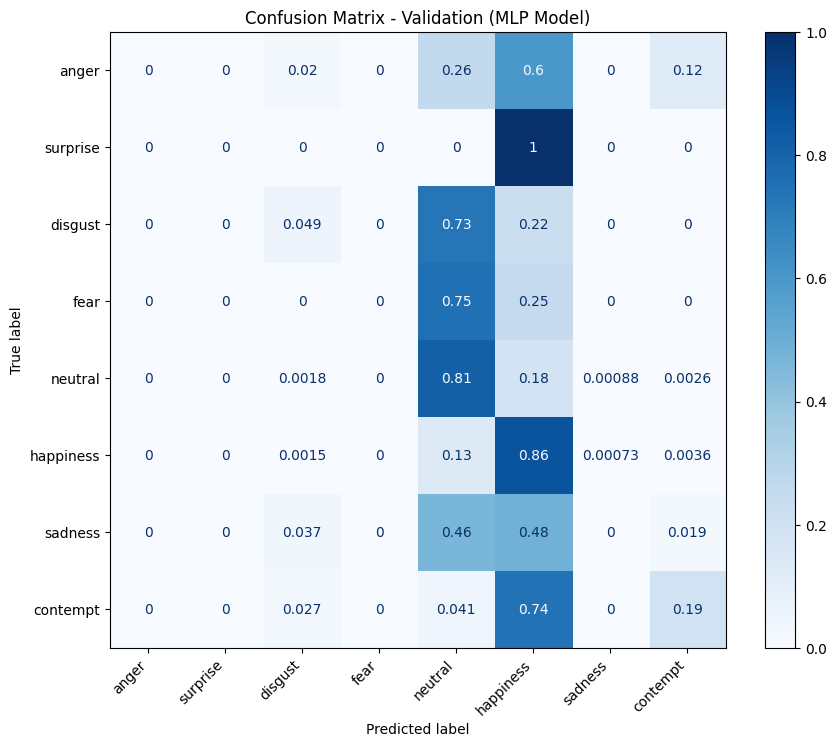

Confusion Matrix (Validation):
[[   0    0    1    0   13   30    0    6]
 [   0    0    0    0    0    2    0    0]
 [   0    0    2    0   30    9    0    0]
 [   0    0    0    0    3    1    0    0]
 [   0    0    2    0  926  207    1    3]
 [   0    0    2    0  182 1184    1    5]
 [   0    0    2    0   25   26    0    1]
 [   0    0    2    0    3   55    0   14]]


In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)

mlp.fit(xtraindata_flat, ytrain)
y_pred = mlp.predict(xvaldata_flat)

cm = confusion_matrix(yval, y_pred,  normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_mapping.values()))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix - MLP")
plt.show()

accuracy = accuracy_score(yval, y_pred)
f1 = f1_score(yval, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(yval, y_pred, target_names=list(class_mapping.values())))